## 第４章　word2vecの高速化

前章ではword2vecの仕組みを学び、CBOWモデルを実装しましたが、その実装にはいくつか問題があります。

大きな問題は、コーパスで扱う語彙数が増えるに従って、計算量が増加し多くの時間がかかってしまいます。

そこで本章では、word2vecの高速化に主眼を置き、word2vecの改善に取り組みます。

4.1 word2vecの改良①

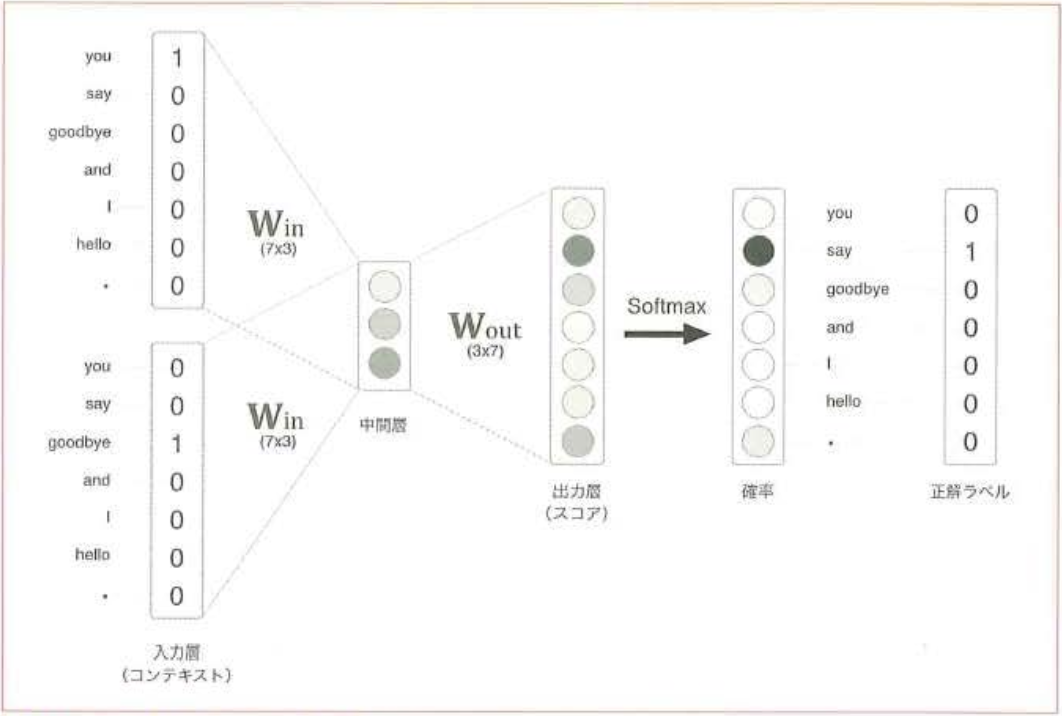

前章のCBOWモデルは2つの単語をコンテキストとして処理し、それを元にひとつの単語（ターゲット）を推測します。このとき、入力側の重み($W_{in}$)との行列の積によって中間層が計算され、出力側の重み ($W_{out}$）との行列の積によって各単語のスコアが求められるのでした。そして、そのスコアがSoftmax関数を経て各単語の出現確率が得られ、それを正解ラベルと比較することで損失が求められたのです。

図4のCBOWモデルは、小さなコーパスを扱う分には特に問題はありません。実際、 図で扱う語棄数は全部で7個でしたが、その規模ではまった＜問題なく処理でさます。しかし、巨大なコーパスを扱う場合いくつか門題が発生します。その問題点を指摘するにあたり、ここではひとつの例として、語彙数が100万の中間ニューロン数が100の場合におけるCBOWモデルを考えたいと思います。

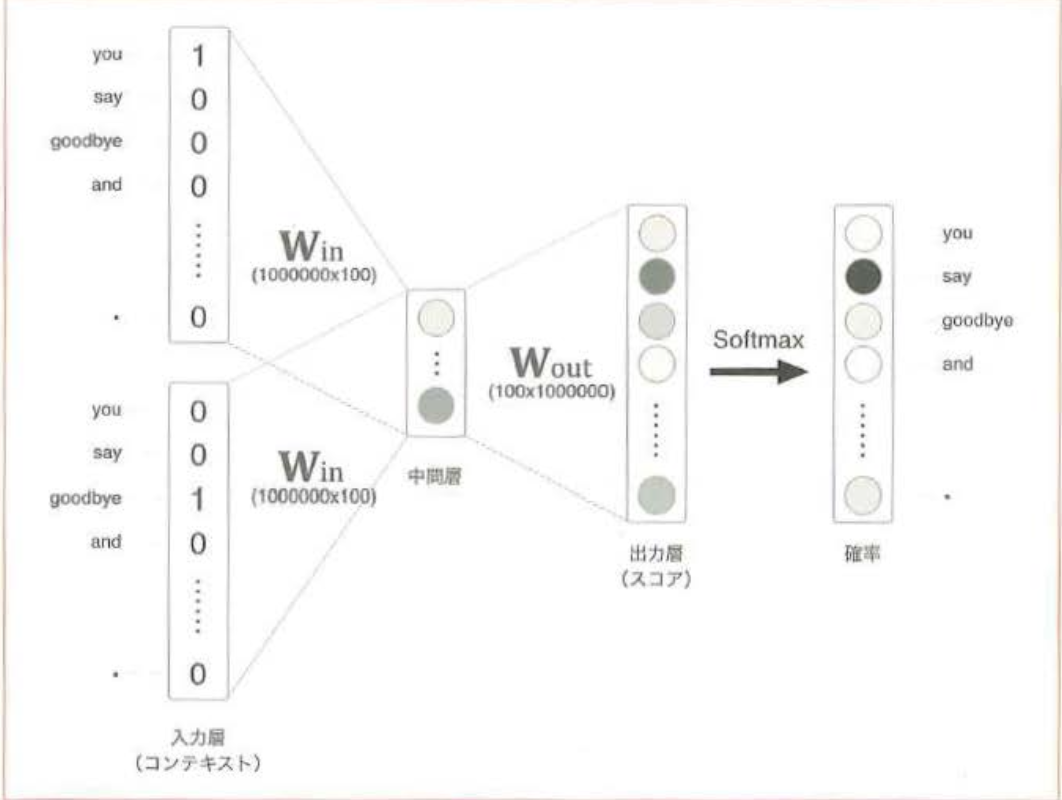

図4が示すとおり、人力層と出力層には100万のニューロンが存在します。この巨大なニューロンによって、途中の計算では多くの時間を要します。具体的には、このとき次の2箇所の計算ががポトルネックとなります。

・ 入力層のone -hot表現と重み行列$W_{in}$の積による計算（4.1節で解決）

・ 中間層と重み行列$W_{out}$の積およぴSoftmaxレイヤの計算 (4.2節で解決）

ひとつ目の問題は、人力層のone-hot表現に関する箇所です。これは、単語をone-hot表現で扱っているため、語棄数が培えるにつれone-hot表現のペクトルのサイズも培えることに起因します。
2つ目の問題は、中間層以降の計算です。まずは中間層と重み行列$W_{out}$の積で多くの計算が必要になります。そして、 Softm邸レイヤに関わる箇所でも、扱う語彙数が増えるにつれて計算量が増加することが問題になります。

4.1.1 Embeddingレイヤ

一つ目の問題の解決策

語彙数が100万の場合、中間層のニューロンの数を１００とすると、MatMulレイヤにおける行列の積は次のようになる。

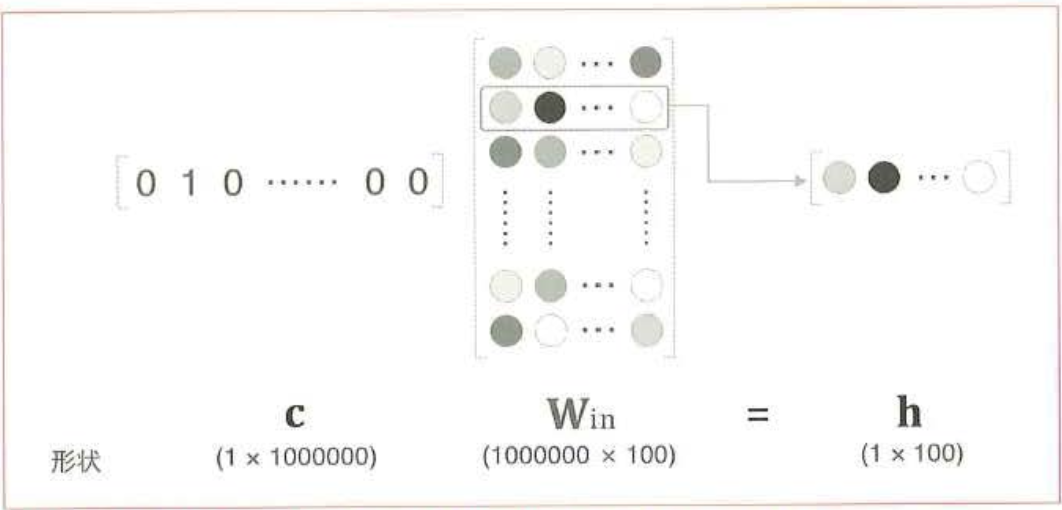

もし100万語の語梨数からなるコーパスがあるとしたら、単
語のone - hot表現の次元数も100万になります。そして、そのような巨大なベクトル
と重み行列の積を計算する必要があるのです。しかし、 図4-3で行っていることは、
単に行列の特定の行を抜き出すことだけです。そのため素直に考えれば、 one - hot表
現への変換とMatMluレイヤでの行列の乗算は必要なさそうです。

では、重みパラメータから「単語IDに該当する行（ベクトル）」を抜き出す
ためのレイヤを作りましょう。ここでは、そのレイヤをEmbeddingレイヤと呼ぷこ
とにします。ちなみに、 Embeddingとは、単語の埋め込み (wordembedding)と
いう用語に由来します。つまり、このEmbeddingレイヤに単語の埋め込み（分散表
現）が格納されるのです。

4.1.2 Embeddingレイヤの実装

行列から行を抜き出す処理は簡単に行えます。たとえぱここで、璽みWがNumPyの2次元配列であるとします。このとき、この重みから特定の行を抜き出すには、 単にW[2]やW[S]のように害くだけです。

In [1]:
import numpy as np
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

この例では、 4つのインデックス (1、0、3、0番目）をまとめて抽出しています。
引数に配列を与えることで、複数の行をまとめて抽出できます。ちなみにこれは、ミ
ニバッチ処理を想定した場合の実装です。
それでは、Embeddingレイヤのforward()メソッ ドを実装しましょう。これま
での例を考えれば、次のような実装になります

In [5]:
class Embedding:
    def __init__self(self, W):
        self.params = [W]
        self.grade = [np.zeros_like(W)]
        self.idx = None

    def forward( self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

続いて、逆伝播 (backward)について考えます。Embeddingレイヤの順伝播は、重みWの特定の行を抜き出すだけでした。これは単に、重みの特定の行のニューロンだけを何の手もえず一次の層へと流したことになります。そのため逆伝播では、前の層から伝わってきた勾配を次の層へそのまま流すだけになります。 ただし前層から伝わる勾配を、重みの勾配 dW の特定の行
(idx)に設定するようにします。


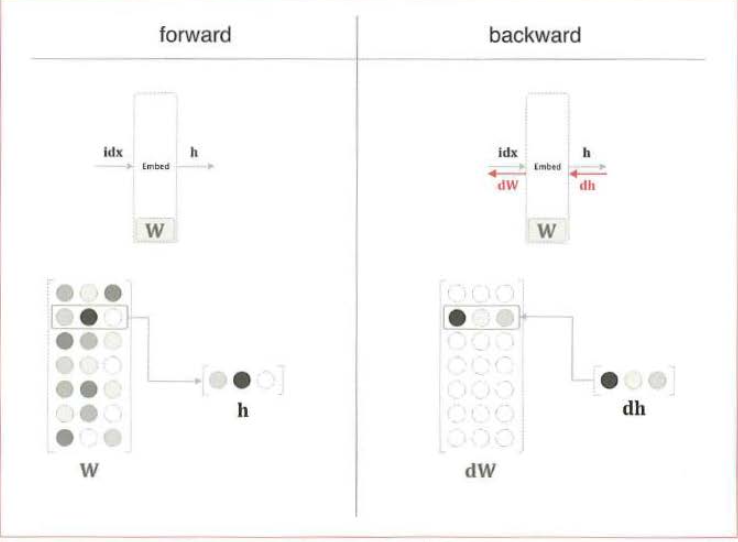


以上を踏まえてbackwardの実装をします。

In [6]:
def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    dW[self.idx] = dout
    return None

ここでは、重みの勾配をdWとして取り出しdW[...)= 0でdWの要素を0で上書きします。 (dWを0にするのではなく、dWの形状を保ったまま、その要素を0にします）。そして、前層から伝わってくる勾配doutを、 idxで指定された行に代入します。

さて、先のbackward(）の実装には、実はひとつ問題があります。その問題は、idxの要素が重複するときに発生します。たとえば、idxが [0,2, 0, 4]のような場合を考えてみましょう。

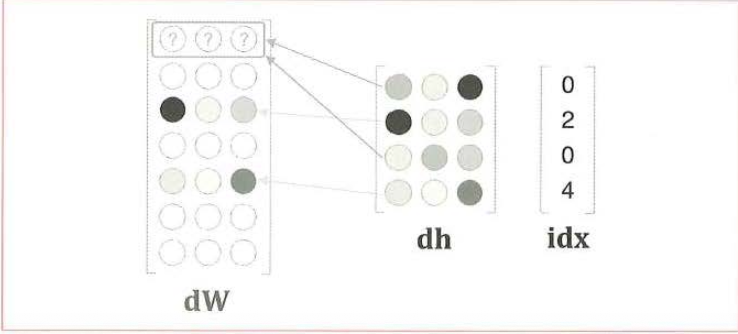

図に示すとおり、dhの各行の値をidxで指走された場所に代入してみます。そうするとこの場合、 dWの0番Hの行に2つの値が代入されることになります。それでは、どちらかの値が上書きされてしまいます。
この重複問題に対応するためには、 「代入」ではなく「加算」を行う必要があります。つまり、 dhの各行の値を、dWの対応する行に加算するのです。

In [7]:
def backward(self, dout):
    dW, = self.grads
    dW[...] = o

    for i, word_id in enumerate(self.idx):
        dW[word_id] += dout[i]

    return None

ここでは、 for文を使って該当するインデックスに勾配を加算します。これで、idxに重複するインデックスがあったとしても正しく処理されます。

以上でEmbeddingレイヤの実装は終わりです。これでword2vec(CBOWモデル）の実装では、入力側のMatMulレイヤをEmbeddingレイヤに切り替えることができます。それによって、 メモリの使用批を減らし、さらに無駄な計算を省くことができるようになりました。

## 4.2 word2vecの改良②

二つ目の解決策

行列の積とsoftmaxレイヤの計算の解決策としてNegtive Sampling(負例サンプリング)と呼ばれる手法を用います。語彙数がどれだけ多くなったとしても、計算量を少なく一定に抑えることかできるのです。

4.2.1 中間層以降の計算の問題点

中間層以降の計算の問題点を指摘するにあたり、前節と同様に語彙数が100万、中間層のニューロン数が100のときのword2vec(CBOWモデル）を考えることにします。

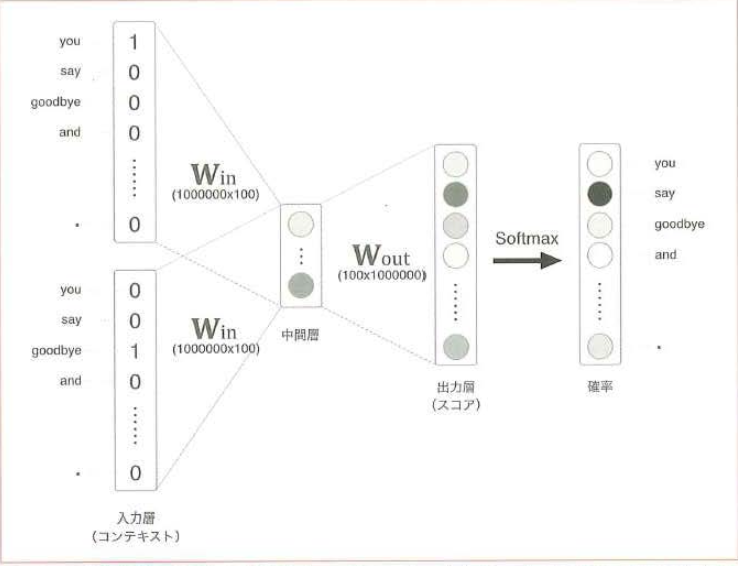

入力層と出力層には100万個のニューロンが存在します。前節ではEmbeddingレイヤを導入することで、入力層の計算については無駄を省くことができました。残る問題は、中間層以降の処理です。このとき、次の2つの場所において多くの計算時間が必要になります。


• 中間層のニューロンと重み行列$W_{out}$の積


• Softmaxレイヤの計算


ひとつ目の問題は巨大な行列の積についてです。上の例では、中間層のペクトルのサイズが100、重み行列のサイズが100x100万になりますが、そのような巨大な行列の積の計算は多くの時間を要します（そして、多くのメモリを必要とします）。さらに、逆伝播のときにも同様の計算を行う必要があるため、その行列の積の計勾を“軽く”することが求められます。

4.2.2 多値分類から二値分類へ

ネガティブサンプリングという手法の重要なアイデアは、「多値分類」の問題を「二値分類」で近似することにあります。従来の手法では、「you」と「goodbye」という文脈から、100万語の中から正解の「say」を選ぶという「多値分類」を行っていました。これに対し、ネガティブサンプリングでは問題を次のように変えます。「文脈が『you』と『goodbye』のとき、ターゲットは『say』ですか？」このように 「Yes/No」で答えられる「二値分類」の問題として扱うことで、ニューラルネットワークの出力層をニューロン一つで構成できるようになり、計算を簡略化できるのです。
この時、CBOWモデルはこのような処理を行います。

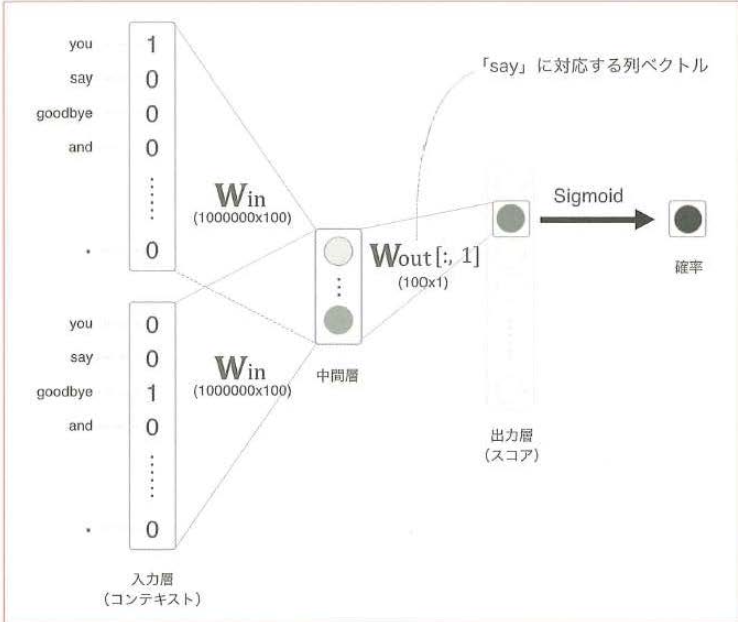

出力層のニューロンはひとつだけです。そのため、中間層と出力層の重み行列の積は、「say 」に対応する列（単語ベクトル）だけを抽出し、その抽出したペクトルと中間層のニューロンとの内積を計算すればよいことになります。この計算は、詳しく書くと

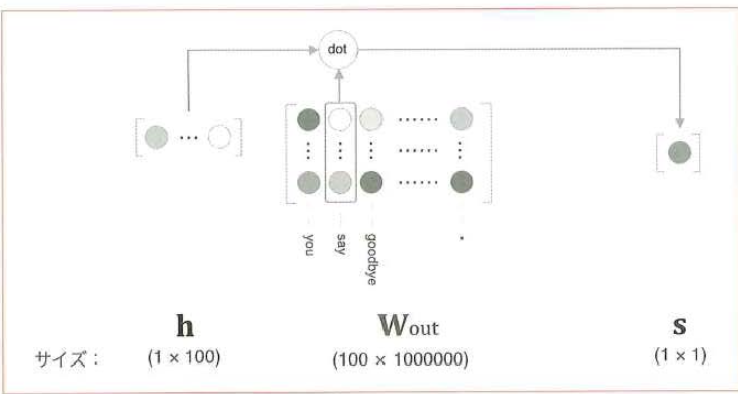

出力側の重み$W_{out}$では、各単語IDの単語ベクトルが各列に格納されています。ここでは、「say」という単語べクトルを抽出します。そして、そのベクトルと中間層のニューロンとの内積を求めます。これが最終的なスコアになります。

4.2.3 シグモイド関数と交差エントロピー誤差

二値分類の問題をニューラルネットワークで解くには、スコアにシグモイド関数を適用し、確率を得ます。そして損失を求めるために、損失関数として「交差エントロピー誤差」を使用します。これは二値分類におけるニューラルネットワークの常套手段です。

シグモイド関数によって確率yを得たら、この確率yから損失を求めます。シグモイド関数に対して使用される損失関数は、多値分類のときと同じく「交差エントロピー誤差」です。

4.2.4 多値分類から二値分類へ(実装編)

ここまでの話を、実装を行う視点で整理したいと思います。私たちはこれまで、多値分類の問題を扱ってきました。そこでは、出力層に語彙数の分だけニューロンを用意し、それをSoftmaxレイヤに通したのです。このとき用いられるニューラルネットワークを、「レイヤ」と「演算」に着目して図示するとこのようになります。

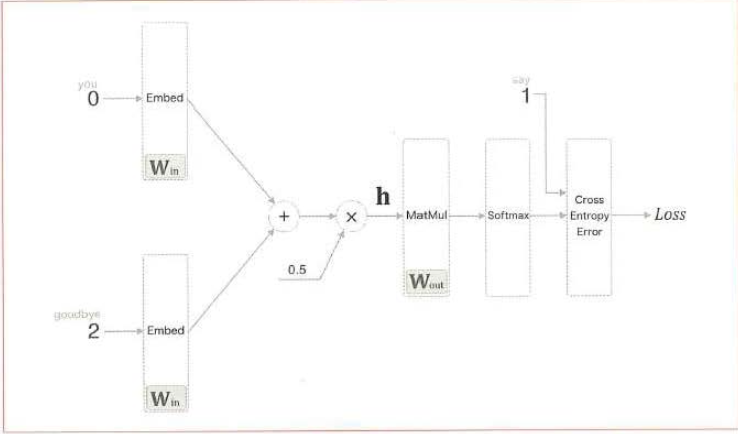

コンテキストが「you」と「goodbye」、正解となるターゲット（予測すべき単語）が「 say 」の場合の例を示しています（単語IDについては「you」が0,「say」が1、「goodbye」が2だと仮定しています）。また入力層では、それぞれに対応する単語IDの分散表現を抜き出すためEmbeddingレイヤを用いています。

それでは、 図4-11のニューラルネットワークを二値分類を行うネットワークに変換します。

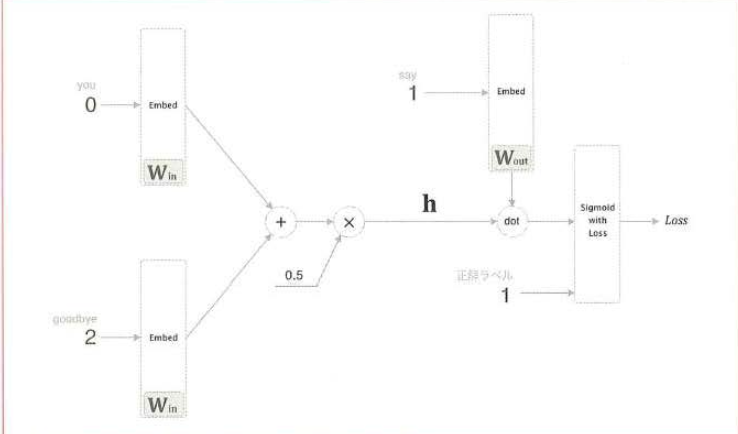

ここでは中間層のニューロンをhとして、出力側の重み$W_{out}$の単語「say」に対応する単語ベクトルとの内積を計算しています。そして、その出力をSigmoid with Lossレイヤに入れることで、最終的な損失を得ます。

ここでは図4-12の後半部分をよりシンプルにしたいと思います。そのために、 Embedding Dotレイヤを導入します。このレイヤは、 図4-12のEmbeddingレイヤと「dot演算」の2つの処理を合わせたレイヤです。

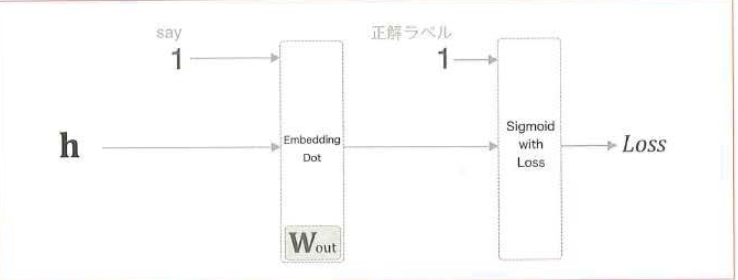

中間層のニューロンhは、EmbeddingDotレイヤを経てSigmoid with Lossレイヤを通ります。見てのとおり、 EmbeddingDotレイヤを使うことで、中問層以降の処理をシンプルに書くことができました。

それではEmbeddingDotレイヤを実装しましょう。

In [8]:
class EmbeddingDot:
    def __init_(self, w):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

EmbeddingDotクラスには、全部で4つのメンバ変数 embed、params、grads、cache があります。本習の実装ルールどおり、paramsにはパラメータを、gradsには勾配をそれぞれ格納します。また、 embedはEmbeddingレイヤを、cacheは順伝播の際に計算した結果を一時的に保持するための変数として使用します。順伝播のforward(h, idx)メソッドでは、引数に中問層のニューロン (h)と単語IDのNumPy配列 (idx)を受け取ります。ここでidxは単語IDの配列になっていますが、これはデータをまとめて処理する 「ミニバッチ処理」を想定しているためです。上のコードのforward(）メソッドでは、まずEmbeddingレイヤの forward(idx)を呼び、続いて内積の計算を行います。内積の計算は、np.sum(self.targeLW * h, axis=l)の 1行によって行われます。この実装を理解するには、具体的な値を見るのが手っ取り早いでしょう。


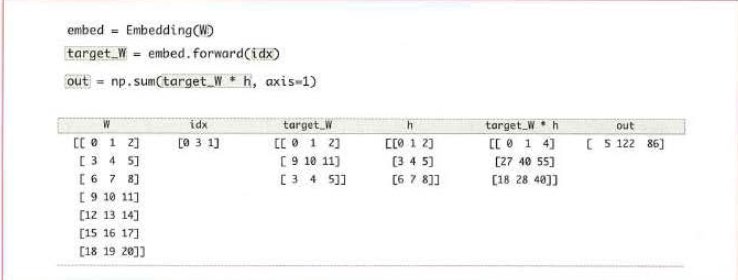


適当なWとh、そしてidxを用意します。ここでidxは[0, 3, 1]ですが、これは3つのデータをミニパッチとしてまとめて処理する例を表しています。idxは[0, 3, 1]なので、target _Wは、 Wの0番、 3番、 1番目の行を抜きだした結果になります。そして、 targetW * hでは、要索ごとの積が計算されます (NumPyの「＊」は要素ごとの積）。 そして、その結呆を行ごとに (axis = 1
によって）総和を求めて、最終的な総和outを得ます。


4.2.5 Negative Sampling


ここまでの議論によって、解くべき問題を「多値分類」から「二値分類」へと変換することができました。しかし、これで問題が解決できたかというと、残念ながらそうではありません。というのも、今のままでは、正例 （ 正しい笞え）についてだけ学判を行ったに過ぎないからです。そのため、負例（誤った答え）については、どのような結果になるのか定かではありません。それでは前の例について、もう一度考えましょう。前の例とは、コンテキストが「 you 」と「goodbye 」で、正解となるターゲットが「say」の場合です。私たちはここまでのところ、正例の「say」だけを対象に二値分類を行ってきました。もしここで、‘‘良い重み＂があれば、 Signoidレイヤの出力(確率）は1に近づくことになるでしょう。


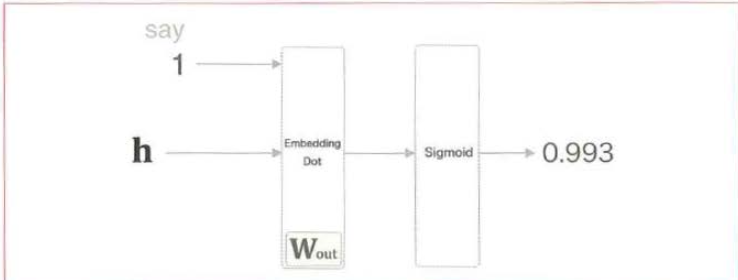


現状のニューラルネットワークでは、正例の「say 」についてだけ学習を行うことになります。しかし、負例「say」以外の単語については、何の知識も身についていません。ここで私たちが本当に行いたいことは何でしょうか。それは、正例(「 say」)についてはSigmoidレイヤの出力を1に近づけ、負例(「say」以外の単語）については、 Sigmoid レイヤの出力を 0 に近づけることなのです。

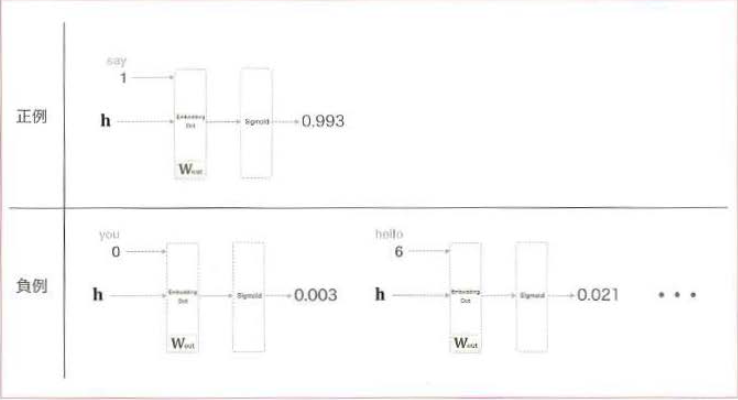

たとえば、コンテキストが「you」と「goodbye」のとき、ターゲットが 「hello 」である確率ー一間巡った単語の場合の確率一ーは低い値であることが望まれます。図4-16では、ターゲットが「helo」のときの確率は0.021( 2.1%)になっていますが、そのような0に近い値を出力するような重みが要求されるのです。

それでは、すべての負例を対象にして、二値分類の学習を行うのでしょうか？ 答えはもちろん「ノー」です。すべての負例を対象にしたのでは、語彙数が増えると手に負えなくなります（そもそも語彙数の増加に対応することが本来の目的でした）。そこで、近似解として負例をいくつか―5個とか、10個とか―ピックアップします（どのように選ぶかについては後述します）。つまり、ネガティブな例（負例）を少数サンプリングして用いるのです。これが「Negative Sampling」という手法の意味するところです。

以上をまとめると、Negative Samplingという手法は、正例をターゲットとした場合の損失を求めます。それと同時に、負例をいくつかサンプリングし（選び出し）、その負例に対しても同様に損失を求めます。そして、それぞれのデータ（正例とサンプリングされた負例）における損失を足し合わせ、その結果を最終的な損失とします。

ここまでの話を、具体的な例を出して説明しましょう。ここでは、これまでと同じ例（正例のターゲットは「say」）を扱います。そして、負例のターゲットを2つサンプリングしたと仮定して、このときサンプリングされた単語が「hello」と「I」だとします。そうした場合、CBOWモデルの中間層以降だけに注目すると、Negative Samplingの計算グラフは次のように書けます。

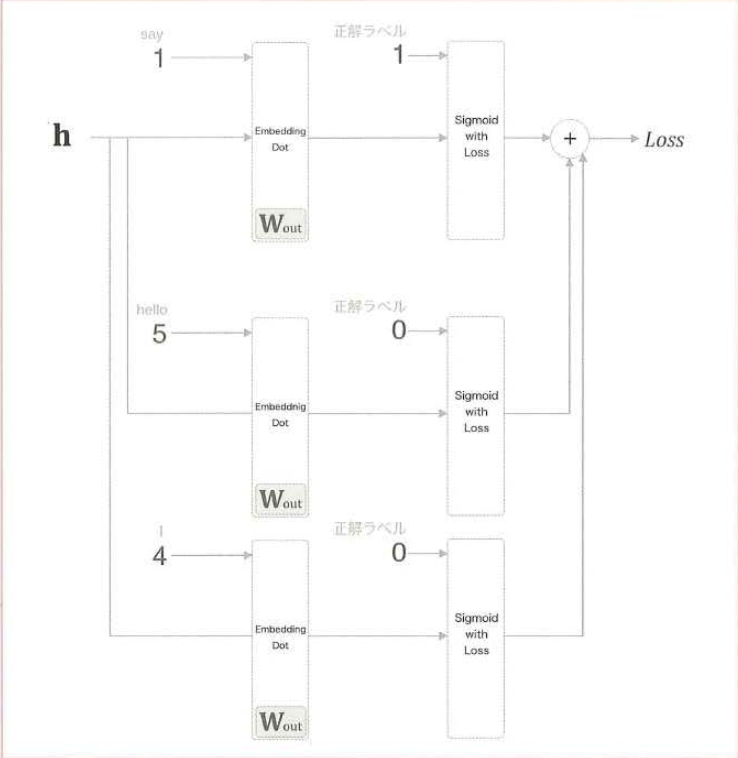

注意すべき点は、正例と負例の扱いについてです。正例(「say 」)については、これまでどおり SigmoidwithLossレイヤヘ正解ラベルとして「1 」を入力します。一方、負例(「 hello」と 「 I 」)については、それが間違った例であるため、Sigmoid with Lossレイヤヘは正解ラベとして「 O」を入力します。後は、それぞれのデータにおける損失を足し合わせて最終的な損失を出力します。

4.2.6 Negtive Samplingのサンプリング手法
 
Negative Samplingについて説明すべきことは、残すところあとひとつになりました。それは、負例をどのようにサンプリングするかということです。これには、ランダムにサンプリングするよりも良い方法が知られています。それは、コーパスの統計データに基づいて、サンプリングを行うのです。具体的に言うと、コーパス中でよく使われる単語は抽出されやすくし、コーバス中であまり使われない単語は抽出されにくくします。コーバス中での単語の使用頻度に甚づいてサンプリングするには、コーパスから各単語の出現した回数を求め、これを「 確率分布」で表します。そして、その確率分布から単語をサンプリングするのです。


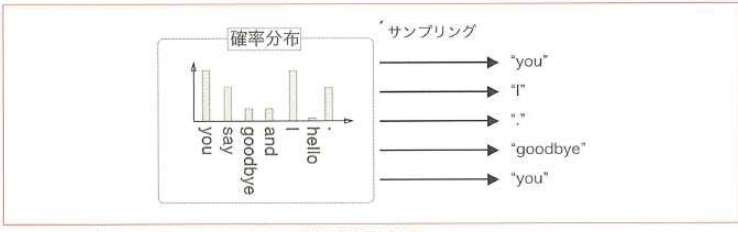


コーパス中の各単語の出現回数を元に確率分布を求めれば、後はその確率分布に従ってサンプリングを行うだけです。確率分布に基づいてサンプリングすることで、コーバス中で多く登場した単語は抽出されやすくなります。一方、“レアな単語”は、抽出されにくくなるのです。それでは、確率分布に従ってサンプリングする例をPythonを使って説明します。この用途には、 NumPynp.random.choice(）メソッドが使えます。ここでは、そのメソッドの使い方を示すため、いくつか使用例を示します。

In [9]:
import numpy as np

np.random.choice(10)

4

In [10]:
np.random.choice(10)

6

In [11]:
words = ['you','say','goodbye', 'I', 'hello', '.']
np.random.choice (words)

'.'

In [12]:
np.random.choice(words, size=5)

array(['I', 'hello', 'you', 'say', 'hello'], dtype='<U7')

In [13]:
np.random.choice(words, size=5, replace=False)

array(['you', '.', 'goodbye', 'hello', 'say'], dtype='<U7')

In [14]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice (words, p=p)

'say'

ここで示すように、np.random.choice()はランダムにサンプリングする用途に利用できます。このとき、引数にsizeを指定すれば、複数回まとめてサンプリングを行います。また、引数に replace=Falseを指定すれば重複をなくしてサンプリングします。そして、引数のpに確率分布を表すリストを指定することで、確率分布に従ってサンプリングが行われます。後は、この関数を使って負例をサンプリングするだけです。

さて、 word2vecで提案されたNegative samplingでは、先の確率分布に対して、一手間加えることが提案されています。それは、式で示すように、元となる確率分布に対して0.75を累乗するのです。
$$
P'(W_i)= \frac {P(W_i)^{0.75}} {\sum_{j}^{n}P(Wj)^{0.75}}
$$


ここで$P(Wi）$は、i番目の単語の確率を表します。これは元の確率分布の各要素を「 0. 75乗」するだけです。ただし、変換後も確率の総和が1になるように、分母には「変換後の確率分布の総和が必要になります。それでは、なぜ式のような変換を行うのでしょうか？それは、出現確率の低い単語を“見捨てない”ようにするためです。より正確に言うと、「0. 75乗」することによって、確率の低い単語に対してその確率を少しだけ高くすることができます。実際に例を示すと、次のようになります。

In [15]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


この例が示すところによれば、変換前は0.01(1% ）の確率だった要素が、変換後は0.026... (2.6... ％）になっています。このように、低確率の単語が（少しだけ）サンプリングされやすくするための救済処置として、 「0. 75乗」を行います。なお、 0.75という数値については理論的な意味はなく、 0.75以外の値に設定することも可能です。以上で見てきたように、Negativesamplingはコーバスから単語の確率分布を作成して、それを「0.75乗」し、先ほどのnp.random.choice()を使って負例をサンプリングします。

4.2.7 Negative Samplingの実装

それでは最後に NegativeSamplingの実装を行います。ここではNegativeSampling Lossというクラスで実装することにします

In [16]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

## 4.3 改良版word2vecの学習

4.3.1 CBOWモデルの実装

ここでは、 CBOWモデルを実装するにあたり、前章の単純なSimpleCBOWクラスを改良することにします。改良点は、 EmbeddingレイヤとNegativeSamplingLossレイヤを使うことです。さらに、コンテキストとして、任意のウィンドウサイズが扱えるように拡張します。

In [17]:
import sys
sys.path.append('..')
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

4.3.2 CBOWモデル学習コード

それでは最後に、CBOWモデルの学習を実装します。ここでは単に、ニューラルネットワークの学習を行うだけになります。

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 4[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 5[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 7[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 8[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 9[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 11[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 12[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 14[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 15[s] | loss 3.15
| epoch 1 |  iter 241 / 9295 | time 16[s] | loss 3.07
| epoch 1 |  iter 261 / 9295 | time 18[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 19[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 21[s] | loss 2.94
| epoch 1 |  iter 321 / 9295 | time 22[s] | loss 2.89
| epoch 1 |  iter 341 / 9295 | time 24[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | time 25[s] 

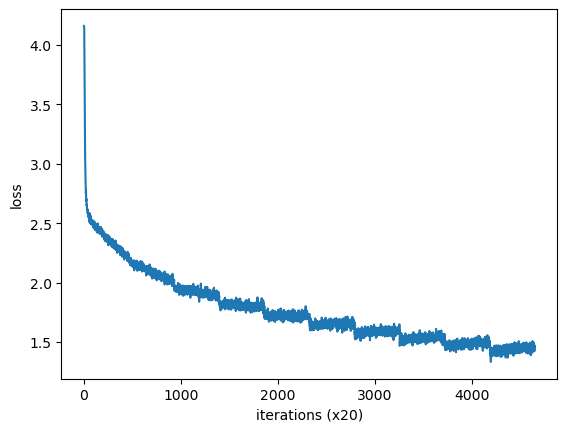

In [22]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)


# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

4.3.3 CBOWモデルの評価

それでは、前節で学習した単語の分散表現を評価したいと思います。

In [23]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)
# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.76416015625
 i: 0.7236328125
 your: 0.63671875
 anybody: 0.60595703125
 they: 0.5947265625

[query] year
 month: 0.85791015625
 week: 0.77978515625
 summer: 0.767578125
 spring: 0.75830078125
 decade: 0.6923828125

[query] car
 window: 0.640625
 luxury: 0.60107421875
 truck: 0.59716796875
 auto: 0.58984375
 merkur: 0.5888671875

[query] toyota
 chevrolet: 0.63330078125
 honda: 0.62744140625
 seita: 0.61962890625
 coated: 0.6103515625
 mazda: 0.60498046875
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.5625
 a.m: 5.2421875
 minute: 4.90234375
 thing: 4.83203125
 husband: 4.703125

[analogy] take:took = go:?
 eurodollars: 4.4609375
 crash: 4.23046875
 're: 4.19140625
 went: 4.14453125
 began: 4.08984375

[analogy] car:cars = child:?
 a.m: 6.85546875
 children: 5.49609375
 rape: 5.3671875
 incest: 5.02734375
 women: 4.8046875

[analogy] good:better = bad:?
 rather: 5.48046875
 more: 5.3515625
 less: 5.203125
 greater: 4.3125


結果を見てみましょう。まずは「you」をクエリとした楊合、類似単語には人称代名詞の「i(=I)」や 「we」などが来ています。続く「 year 」をクエリとした場合は、「month」や「week」などの期間を表す同じ性質の単語が見られます。そして「toyota」をクエリとした場合は「ford 」や 「mazda J 、「nissan」といった自動車メーカーが得られています。このような結果を見ると、 CBOWモデルで獲得された単語の分散表現は、良い性質を持っていると言えそうです。

## まとめ

本章では、 word2vccの高速化をテーマに、前章のCBOWモデルに対して改良を加えました。具体的には、 Embeddit1gレイヤを実装しNegativeSamplingという新しい手法を芍入しました。この行列には、コーバスの語彙数が増えるのに比例し、計算量が増加することが挙げられます。本章での重要なテーマは、 「すぺて」ではなく「一部」を処理することです。結局のところ、人間がすべてを矧ることができないように、コンピュータも（ 現在の性能では）すべてのデータを処理することは現実的ではありません。それよりも、自分にとって大切な少数のことに限定して取り組むほうが実りが多いのです。本究ではその考えに基づく手法— Negative smpling~ ました 。 Negative
samplingは、すべて」の単語ではなく、「一部」の単語だけを対象にすることで、計計算の効率化を達成しました。
前章と本章にて、 word2vecをテーマとする一連の話は終わりです。word2vecは自然言額の分野に多大な影響を与えてきました。そこで得られた単語の分散表現は、さまざまな自然言語処列のタスクに利用されています。さらにword2vccの思想は、自然言語だけではなく他の分野、音声、画像、動画などにも応用されています。本章でword2vecをしっかりと狸鮒したのであれば、その知識はさまざまな分野で役に立つはずです。